# C-c C-v from the other file :)

In [80]:
import numpy as np
import math
# import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, LearningRateScheduler
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import BatchNormalization, Activation, Conv2D, Input, MaxPooling2D, Add, GlobalAveragePooling2D, Reshape, Bidirectional, Dense, Flatten, Dropout, SpatialDropout2D
from keras.layers import LSTM, RepeatVector, Concatenate, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adadelta
from tensorflow.math import exp, log
from time import time
from collections import Counter
import matplotlib.pyplot as plt
import os
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix   
import wave
import librosa
import soundfile as sf
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20,7)

In [2]:
class ResNetLstm():
    """
    Usage: 
        sr = ResNetLstm([4,8,16], input_size=(50,50,1), output_size=12)
        sr.build()
        followed by sr.m.compile(loss='categorical_crossentropy', 
                                 optimizer='adadelta', metrics=["accuracy"])
        save plotted model with: 
            keras.utils.plot_model(sr.m, to_file = '<location>.png', 
                                   show_shapes=True)
    """
    def __init__(self,
                 filters_list=[], 
                 input_size=None, 
                 output_size=None,
                 initializer='glorot_uniform'):
        self.filters_list = filters_list
        self.input_size = input_size
        self.output_size = output_size
        self.initializer = initializer
        self.m = None        
    
    def _block(self, filters, inp):
        """ one residual block in a ResNetLstm
        
        Args:
            filters (int): number of convolutional filters
            inp (tf.tensor): output from previous layer
            
        Returns:
            tf.tensor: output of residual block
        """
        layer_1 = BatchNormalization()(inp)
        act_1 = Activation('relu')(layer_1)
        conv_1 = Conv2D(filters, (3,3), 
                        padding = 'same', 
                        kernel_initializer = self.initializer)(act_1)
        layer_2 = BatchNormalization()(conv_1)
        act_2 = Activation('relu')(layer_2)
        conv_2 = Conv2D(filters, (3,3), 
                        padding = 'same', 
                        kernel_initializer = self.initializer)(act_2)
        return(conv_2)
    def build(self):
        """
        Returns:
            keras.engine.training.Model
        """

        print('1shapes: ', self.input_size)
        i = Input(shape = self.input_size, name = 'input')
        x = Conv2D(self.filters_list[0], (3,3), 
                   padding = 'same',
                   kernel_initializer = self.initializer)(i)
        print('2shapes: ', x.shape)
        x = MaxPooling2D((1,3))(x)
        # x = MaxPooling2D(padding = 'same')(x)
        print('3shapes: ', x.shape)
        x = Add()([self._block(self.filters_list[0], x),x])
        x = Add()([self._block(self.filters_list[0], x),x])
        x = Add()([self._block(self.filters_list[0], x),x])
        if len(self.filters_list) > 1:
            for filt in self.filters_list[1:]:
                print(filt)
                x = Conv2D(filt, (3,3),
                           strides = (1,1),
                           padding = 'same',
                           activation = 'relu',
                           kernel_initializer = self.initializer)(x)
                x = MaxPooling2D((1,3))(x)
                print('6shapes: ', x.shape)
                x = Add()([self._block(filt, x),x])
                x = Add()([self._block(filt, x),x])
                x = Add()([self._block(filt, x),x])
        # x = GlobalAveragePooling2D()(x)
        
        x = Reshape((85,4*32))(x)
        print('7shapes: ', x.shape)
        x = Bidirectional(LSTM(64,return_sequences=True))(x)
        print('8shapes: ', x.shape)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Bidirectional(LSTM(32,return_sequences=True))(x)
        print('9shapes: ', x.shape)
        x = Reshape((85,2*32))(x)
        print('0shapes: ', x.shape)
        print('output_size: ', self.output_size)
        x = Flatten()(x)
        print('1shapes: ', x.shape)
        x = Dropout(0.2)(x)
        
        x = Dense(self.output_size, activation = 'softmax')(x)
        print('2shapes: ', x.shape)
        
        self.m = Model(i,x)
        return self.m

In [3]:
# path = '/home2/faculty/kmrozowski/rl2/wut-mini-deep-learning/speech-recognition/'
path = '/home/metiulekm/wut-mini-deep-learning/speech-recognition/'
X_train = np.load(path+'data/X_train.npy').transpose((0,2,1,3))
Y_train = np.load(path+'data/Y_train.npy')
X_train = X_train[1::4, ...]
Y_train = Y_train[1::4, ...]
X_val = np.load(path+'data/X_val.npy').transpose((0,2,1,3))
Y_val = np.load(path+'data/Y_val.npy')

In [4]:
# This is augumentation, I don't know if we want to keep this. For now, let's comment it out
#X_train_flipped = np.flip(X_train, 2)
#Y_train_flipped = Y_train.copy()
#Y_train_flipped[Y_train != 10] = 11
#X_train = np.append(X_train, X_train_flipped, 0)
#Y_train = np.append(Y_train, Y_train_flipped)

In [5]:
path = '/home/metiulekm/wut-mini-deep-learning/speech-recognition/'
# path = '/dev/shm/kmrozowski/'
classes = ['yes', 'no', 
           'up', 'down', 
           'left', 'right', 
           'on', 'off', 
           'stop', 'go', 
           'silence', 'unknown']
all_classes = [x for x in classes[:11]]
for ind, cl in enumerate(os.listdir(path + 'data/train/audio/')):
    if cl not in classes:
        all_classes.append(cl)
classes_known = classes[:-1]
print(all_classes, '-->', classes_known)

['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence', 'bed', 'bird', 'cat', 'dog', 'eight', 'five', 'four', 'happy', 'house', 'marvin', 'nine', 'one', 'seven', 'sheila', 'six', 'three', 'tree', 'two', 'wow', 'zero'] --> ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence']


In [6]:
def binarize_classes(set, target):
    ret = set.copy()
    for i, class_idx in enumerate(ret):
        if classes[class_idx] == target:
            ret[i] = 1
        else:
            ret[i] = 0
    return ret

In [7]:
def get_class_weights(set):
   counter = Counter(set)
   majority = max(counter.values())
   return  {cls: float(majority/count) for cls, count in counter.items()}

In [8]:
input_size = X_train.shape[1:]
batch_size = 196

In [17]:
filters_list = [8,16,32]
output_size_binary = 2

In [18]:
#adjust these strings for organizeing the saved files
date = '20220502'
arch_without_suffix = 'resnetlstm8_16_32_binary_'

In [11]:
def step_decay(epoch):
   initial_lrate = 0.4
   # drop = 0.5
   # epochs_drop = 10.0
   fastest_decay_epicentrum = 600
   epochs_of_fast_decaying = 200
   lrate = initial_lrate * (math.atan(-(epoch-fastest_decay_epicentrum)/epochs_of_fast_decaying) + 0.915 * math.pi/2) * 0.34
   # lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
   return lrate


v = np.arange(1,200,1)
w = [step_decay(x) for x in v]
print(w[-1])

0.346177849024205


In [19]:
sr = {}
for target in classes_known:
    print(target)
    arch = arch_without_suffix + target
    sr[target] = ResNetLstm(filters_list, input_size, output_size_binary)
    sr[target].build()
    sr[target].m.compile(loss='categorical_crossentropy', 
                         optimizer=Adadelta(learning_rate=1.0,
                                            rho=0.95,
                                            epsilon=1e-07,
                                            name="Adadelta"),
                         metrics=['accuracy'])
    plot_model(sr[target].m,
               to_file = './models/{}_{}.png'.format(arch,date), 
               show_shapes = True)
    Y_train_target = binarize_classes(Y_train, target)
    Y_val_target = binarize_classes(Y_val, target)
    checkpointer = ModelCheckpoint(filepath='./models/{}_{}_best.h5'.format(arch, date),
                                   verbose=0,
                                   save_best_only=True)
    earlystopping = EarlyStopping()
    tensorboard = TensorBoard(log_dir = './logs/{}_{}'.format(date, time()), 
                              histogram_freq = 0, 
                              write_graph = True, 
                              write_images = True)
    sheluder = LearningRateScheduler(step_decay, verbose=0)
    history = sr[target].m.fit(X_train, 
                               to_categorical(Y_train_target),
                               batch_size = batch_size,
                               #epochs = 1000,
                               epochs = 3,
                               verbose = 1, shuffle = True, 
                               class_weight = get_class_weights(Y_train_target),
                               validation_data = (X_val, to_categorical(Y_val_target)), 
                               callbacks = [checkpointer, tensorboard, sheluder]) # add more callbacks if you want

yes
1shapes:  (85, 122, 1)
2shapes:  (None, 85, 122, 8)
3shapes:  (None, 85, 40, 8)
16
6shapes:  (None, 85, 13, 16)
32
6shapes:  (None, 85, 4, 32)
7shapes:  (None, 85, 128)
8shapes:  (None, 85, 128)
9shapes:  (None, 85, 64)
0shapes:  (None, 85, 64)
output_size:  2
1shapes:  (None, 5440)
2shapes:  (None, 2)
Epoch 1/3
75/75 [==============================] - 82s 1s/step - loss: 0.8600 - accuracy: 0.7855 - val_loss: 0.5929 - val_accuracy: 0.8952 - lr: 0.3653
Epoch 2/3
75/75 [==============================] - 76s 1s/step - loss: 0.4493 - accuracy: 0.9056 - val_loss: 0.4060 - val_accuracy: 0.9563 - lr: 0.3653
Epoch 3/3
75/75 [==============================] - 74s 994ms/step - loss: 0.2565 - accuracy: 0.9485 - val_loss: 0.1858 - val_accuracy: 0.9618 - lr: 0.3652
no
1shapes:  (85, 122, 1)
2shapes:  (None, 85, 122, 8)
3shapes:  (None, 85, 40, 8)
16
6shapes:  (None, 85, 13, 16)
32
6shapes:  (None, 85, 4, 32)
7shapes:  (None, 85, 128)
8shapes:  (None, 85, 128)
9shapes:  (None, 85, 64)
0shapes:  

75/75 [==============================] - 78s 1s/step - loss: 0.0629 - accuracy: 0.9886 - val_loss: 0.4294 - val_accuracy: 0.9029 - lr: 0.3653
Epoch 3/3
75/75 [==============================] - 78s 1s/step - loss: 0.0578 - accuracy: 0.9898 - val_loss: 0.4431 - val_accuracy: 0.7970 - lr: 0.3652


In [27]:
for target in classes_known:
    sr[target].m.trainable = False

# Combined model

In [91]:
i = Input(shape = input_size, name = 'input')
xs = {}
for target in classes_known:
    xs[target] = sr[target].m(i)[:, 1]
    xs[target] = Lambda(lambda x: log(1 / (1 + exp(-x))))(xs[target]) # To "undo" softmax
    xs[target] = Reshape((1,))(xs[target])
xs_known = Concatenate(axis=1)(xs.values())
xs_unknown = Dense(1)(xs_known)
xs_all = Concatenate(axis=1)([xs_known, xs_unknown])
xs_all = Activation('softmax')(xs_all)
final_model = Model(i, xs_all)

In [92]:
final_model.compile(loss='categorical_crossentropy', 
                    optimizer=Adadelta(learning_rate=1.0,
                                       rho=0.95,
                                       epsilon=1e-07,
                                       name="Adadelta"),
                    metrics=['accuracy'])

In [93]:
#adjust these strings for organizeing the saved files
arch = 'resnetlstm8_16_32_combined'

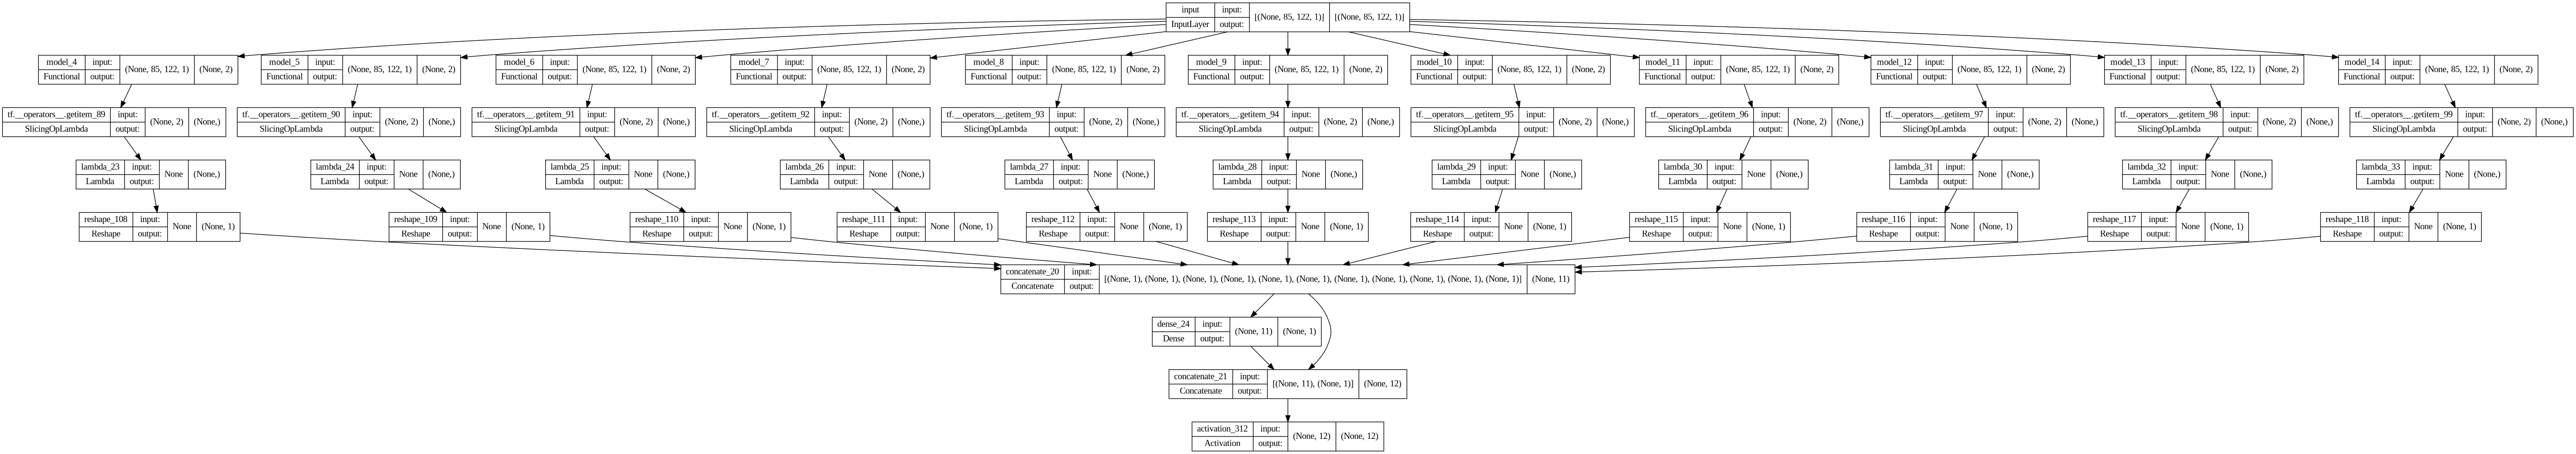

In [94]:
# So ugly!
plot_model(final_model,
           to_file = './models/{}_{}.png'.format(arch,date), 
           show_shapes = True)

In [95]:
#callbacks, remember to make folders to store files 
checkpointer = ModelCheckpoint(filepath='./models/{}_{}_best.h5'.format(arch, date),
                               verbose=0,
                               save_best_only=True)
   
earlystopping = EarlyStopping()

tensorboard = TensorBoard(log_dir = './logs/{}_{}'.format(date, time()), 
                          histogram_freq = 0, 
                          write_graph = True, 
                          write_images = True)
sheluder = LearningRateScheduler(step_decay, verbose=0)

In [96]:
history = final_model.fit(X_train, 
                   to_categorical(Y_train), 
                   batch_size = batch_size, 
                   #epochs = 1000,
                   epochs = 3,
                   verbose = 1, shuffle = True, 
                   class_weight = get_class_weights(Y_train),
                   validation_data = (X_val, to_categorical(Y_val)), 
                   callbacks = [checkpointer, tensorboard, sheluder]) # add more callbacks if you want

Epoch 1/3
75/75 [==============================] - 241s 3s/step - loss: 18.9345 - accuracy: 0.6318 - val_loss: 2.0043 - val_accuracy: 0.6172 - lr: 0.3653
Epoch 2/3
75/75 [==============================] - 189s 3s/step - loss: 18.7529 - accuracy: 0.6318 - val_loss: 2.0948 - val_accuracy: 0.6172 - lr: 0.3653
Epoch 3/3
75/75 [==============================] - 188s 3s/step - loss: 18.6392 - accuracy: 0.6318 - val_loss: 2.1766 - val_accuracy: 0.6172 - lr: 0.3652


# Testing blablabla

In [97]:
val_pred = final_model.predict(X_val, batch_size = batch_size, verbose = 1)

35/35 [==============================] - 72s 2s/step


In [98]:
print(classification_report(Y_val, np.argmax(val_pred, axis = 1), target_names = classes, digits = 3))

              precision    recall  f1-score   support

         yes      0.000     0.000     0.000       261
          no      0.000     0.000     0.000       270
          up      0.000     0.000     0.000       260
        down      0.000     0.000     0.000       264
        left      0.000     0.000     0.000       247
       right      0.000     0.000     0.000       256
          on      0.000     0.000     0.000       257
         off      0.000     0.000     0.000       256
        stop      0.000     0.000     0.000       246
          go      0.000     0.000     0.000       260
     silence      0.000     0.000     0.000        41
     unknown      0.617     1.000     0.763      4221

    accuracy                          0.617      6839
   macro avg      0.051     0.083     0.064      6839
weighted avg      0.381     0.617     0.471      6839



/home/metiulekm/.local/share/virtualenvs/speech-recognition-YZGLRYX1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/metiulekm/.local/share/virtualenvs/speech-recognition-YZGLRYX1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/metiulekm/.local/share/virtualenvs/speech-recognition-YZGLRYX1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. U

In [99]:
print(confusion_matrix(Y_val, np.argmax(val_pred, axis = 1)))

[[   0    0    0    0    0    0    0    0    0    0    0  261]
 [   0    0    0    0    0    0    0    0    0    0    0  270]
 [   0    0    0    0    0    0    0    0    0    0    0  260]
 [   0    0    0    0    0    0    0    0    0    0    0  264]
 [   0    0    0    0    0    0    0    0    0    0    0  247]
 [   0    0    0    0    0    0    0    0    0    0    0  256]
 [   0    0    0    0    0    0    0    0    0    0    0  257]
 [   0    0    0    0    0    0    0    0    0    0    0  256]
 [   0    0    0    0    0    0    0    0    0    0    0  246]
 [   0    0    0    0    0    0    0    0    0    0    0  260]
 [   0    0    0    0    0    0    0    0    0    0    0   41]
 [   0    0    0    0    0    0    0    0    0    0    0 4221]]


In [100]:
!pip install seaborn
import seaborn as sns

In [103]:
cf_mat = confusion_matrix(Y_val, np.argmax(val_pred, axis = 1))
b = cf_mat.copy()
sum = 0.0
sum_diag = 0.0
for i in range(cf_mat.shape[0]-1):
   for j in range(cf_mat.shape[0]-1):
      if j != i:
         sum += cf_mat[i][j]
      else:
         sum_diag += cf_mat[i][j]
acc = sum_diag / (sum + sum_diag)
print('acc =', acc)

acc = nan


/tmp/ipykernel_11583/2999415010.py:11: RuntimeWarning: invalid value encountered in double_scalars
  acc = sum_diag / (sum + sum_diag)


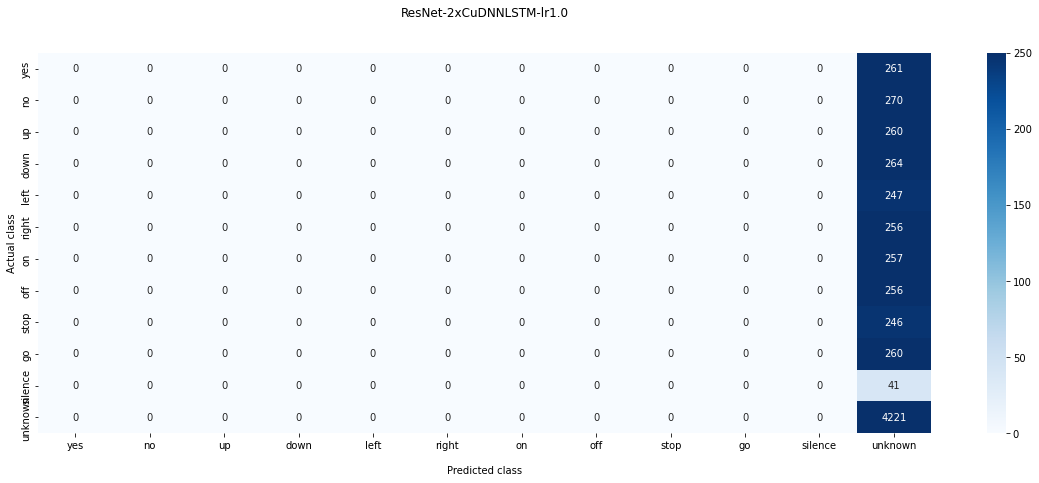

In [104]:
ax = sns.heatmap(cf_mat, annot=cf_mat, fmt='', cmap='Blues', vmin=0, vmax=250)
ax.set_title('ResNet-2xCuDNNLSTM-lr1.0\n\n')
ax.set_xlabel('\nPredicted class')
ax.set_ylabel('Actual class')
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(classes)
ax.yaxis.set_ticklabels(classes)
plt.show()